In [1]:
import project_path
import os
import numpy as np
import json
from tqdm import tqdm
from typing import List, Dict, Any, Union, Tuple
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pandas as pd

from attwizard.decoder import get_attention_representation
from attwizard.aligner import map_to_char_level
from attwizard.aligner import tokenize_char_level

from codeattention.source_code import SourceCode

from scipy.stats import spearmanr
from scipy.stats import kstest
from scipy.spatial.distance import jensenshannon

from attwizard.script.utils import read_data_in_parallel
from attwizard.script.utils import load_json_file

# EDA
from attwizard.visualizer.eda import visualize_corr_vs
from attwizard.visualizer.eda import visualize_code_heatmap_codegen
from attwizard.visualizer.eda import plot_histogram_in_parallel

# Goal
Here we study how well the followup and the competitor methods align with the ground truth code exploration.
We consider both CodeGen and GPT-J.

In [2]:
%load_ext autoreload
%autoreload 2

In [36]:
COMPARISON_FOLDER_CODEGEN = "cmp_v06"
OUT_PAPER_FOLDER = "../data/paper_figures"
MASTER_DATA_FOLDER = "../data/iclr2023data"

# CodeGen

In [26]:
model_dfs = [] 

for folder in [
        COMPARISON_FOLDER_CODEGEN, 
        #COMPARISON_FOLDER_GPTJ
        ]:
    # LOAD COMPARISON DATA
    path_comparison_dir = f'../data/comparisons/{folder}/'
    #available_comparisons = os.listdir(path_comparison_dir)
    #dfs = []
    dfs = read_data_in_parallel(
        base_folder=path_comparison_dir,
        file_type_extension='.csv',
        read_function=pd.read_csv,
        n_processes=20,
        extra_filter_regex='tl_spearman_divide_all_dist.*|tl_top3_divide_all_dist.*'
    )
    #for comparison in tqdm(available_comparisons):
    #    df = pd.read_csv(os.path.join(path_comparison_dir, comparison))
    #    dfs.append(df)
    df = pd.concat(dfs)
    all_comparisons = list(df["comparison_name"].unique())
    model_dfs.append(df)

df_codegen = model_dfs[0]
#df_gptj = model_dfs[1]



n of data read:  62


In [30]:
relevant_columns = [
    "comparison_name",
    "input_human_filestem",
    "input_machine_filestem",
    "spearman_res.corr", 'spearman_res.pval', 'spearman_res.token_index',
    "top_3.token_index", 'top_3.value',
    'top_3.top_k_machine', 'top_3.top_k_groud_truth',
    'human_a', 'human_b', 
]

df_codegen_slim = df_codegen[relevant_columns]
# print the space occupied in memory
print(f"df_codegen_slim: {df_codegen_slim.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

df_codegen_slim: 4118.69 MB


In [37]:
# save in the MASTER_DATA_FOLDER
df_codegen_slim.to_csv(os.path.join(MASTER_DATA_FOLDER, "df_codegen_comparisons_and_abl_study.csv"), index=False)

In [27]:
sorted(list(df_codegen["comparison_name"].unique()))

['tl_spearman_divide_all_dist_copycat',
 'tl_spearman_divide_all_dist_followup',
 'tl_spearman_divide_all_dist_followup_layer_pair_0',
 'tl_spearman_divide_all_dist_followup_layer_pair_12',
 'tl_spearman_divide_all_dist_followup_layer_pair_15',
 'tl_spearman_divide_all_dist_followup_layer_pair_18',
 'tl_spearman_divide_all_dist_followup_layer_pair_21',
 'tl_spearman_divide_all_dist_followup_layer_pair_24',
 'tl_spearman_divide_all_dist_followup_layer_pair_27',
 'tl_spearman_divide_all_dist_followup_layer_pair_3',
 'tl_spearman_divide_all_dist_followup_layer_pair_30',
 'tl_spearman_divide_all_dist_followup_layer_pair_32',
 'tl_spearman_divide_all_dist_followup_layer_pair_6',
 'tl_spearman_divide_all_dist_followup_layer_pair_9',
 'tl_spearman_divide_all_dist_followup_max_10_all_layers',
 'tl_spearman_divide_all_dist_followup_max_50_all_layers',
 'tl_spearman_divide_all_dist_gauss_neigh_1000',
 'tl_spearman_divide_all_dist_gauss_neigh_200',
 'tl_spearman_divide_all_dist_gauss_neigh_30',
 

# Token visibility data
Get for each developer session the info on how long each token was visible for a given human.
These visibility time will become the weight to use in the WEIGHTED histogram.

In [28]:
# LOAD THE TOKEN INFORMATION
HUMAN_ATT_ON_CODEGEN_TOKENS_METADATA_FODLER = '../data/eye_tracking_attention/eye_v10/att_weights_Salesforce_codegen-16B-multi/metadata'
codegen_tokens = read_data_in_parallel(
    base_folder=HUMAN_ATT_ON_CODEGEN_TOKENS_METADATA_FODLER,
    file_type_extension='.json',
    read_function=load_json_file
)
all_tokens = [v for k, v in codegen_tokens.items()]
# flattent the list
all_tokens = [item for sublist in all_tokens for item in sublist]
df_tokens = pd.DataFrame.from_records(all_tokens)
# compute the total time spent in each session to normalize the weights
df_total_times = df_tokens.groupby('id').agg({'w': 'sum'}).reset_index()
df_total_times.rename(columns={'w': 'total_time'}, inplace=True)
# join the two tables and compute the percentage of total time with column w and column total_time
df_tokens_w_time = df_tokens.merge(df_total_times, on='id')
df_tokens_w_time['n_replicas_abs'] = df_tokens_w_time['w'].astype(int)
df_tokens_w_time['perc_time'] = df_tokens_w_time['w'] / df_tokens_w_time['total_time']
df_tokens_w_time['n_replicas_perc'] = df_tokens_w_time['perc_time'].apply(
    lambda x: round(x * 1000))
# rename the columns to join
df_tokens_w_time.rename(columns={
    'id': 'input_human_filestem',
    'i': 'token_index'}, inplace=True)
df_tokens_w_time.head()

n of data read:  92


,s,token_index,c,l,t,w,model,input_human_filestem,total_time,n_replicas_abs,perc_time,n_replicas_perc
0,0,0,0,0,#,0.0,Salesforce/codegen-16B-multi,0480e5,6607.23048,0,0.0,0
1,1,1,1,0,********************************,0.0,Salesforce/codegen-16B-multi,0480e5,6607.23048,0,0.0,0
2,34,2,34,0,********************************,0.0,Salesforce/codegen-16B-multi,0480e5,6607.23048,0,0.0,0
3,66,3,66,0,********,0.0,Salesforce/codegen-16B-multi,0480e5,6607.23048,0,0.0,0
4,74,4,74,0,***,0.0,Salesforce/codegen-16B-multi,0480e5,6607.23048,0,0.0,0


In [29]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=False)

def enrich_with_time_weights(df, df_tokens_w_time, short_col_name: str):
    """Add the column telling how long a human spent on a FROM token"""
    # enrich the dataset with the token position and replicate the 
    # records depending on how much time the user spent on that starting
    # token
    df_tokens_w_time_copy = df_tokens_w_time
    df_tokens_w_time_copy = df_tokens_w_time_copy.rename(columns={
        'input_human_filestem': 'unified_input_human_filestem',
        'token_index': f'{short_col_name}.token_index'})
    # check that human_a is not null
    df['unified_input_human_filestem'] = df.parallel_apply(
        lambda row: row['human_a'] 
            if ('human_a' in row.keys() and row['human_a'] is not None and not pd.isna(row['human_a']))
            else row['input_human_filestem'],
        axis=1
    )
    #display(df[['unified_input_human_filestem', 'human_a', 'input_human_filestem']].head())
    #df.info()
    #df_tokens_w_time_copy.info()
    # if 'human_a' in df.columns:
    #     len_input_human_filestem = df[
    #         'input_human_filestem'].notnull().sum()
    #     len_column_human_a = df[
    #         'human_a'].notnull().sum()
    #     if len_column_human_a > len_input_human_filestem:
    #         # drop the column input_human_filestem
    #         df = df.drop(
    #             columns=['input_human_filestem'])
    #         df = df.rename(columns={
    #             'human_a': 'input_human_filestem'})
    df = df.merge(
        df_tokens_w_time_copy,
        on=['unified_input_human_filestem', f'{short_col_name}.token_index'], 
        how='left')
    return df


def replicated_based_on_weights(df, weight_column_name: str):
    """Replicate the records based on the weight column"""
    df = df.reset_index(drop=True)
    # repeat the rows based on the integer weight contained in the column
    # weights_column_name
    df = df.reindex(df.index.repeat(df[weight_column_name]))
    df = df.reset_index(drop=True)
    #df = df.loc[
    #    np.repeat(df.index.values, df[weight_column_name])]
    return df


def replicated_based_on_token_visibility(
        df, 
        df_tokens_w_time,
        short_col_name: str,
        weight_column_name: str):
    """Replicate the records based on the weight column"""
    df = enrich_with_time_weights(df, df_tokens_w_time, short_col_name)
    df = replicated_based_on_weights(df, weight_column_name)
    return df

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Agreement: Interaction Matrix

1. Base distribution: based on distance: `eye_v10/decay_0.1_Salesforce_codegen-16B-multi/data_avg_followup/df_base_all_prob_based_on_distance.csv`
1. Normalization operation: divide
1. How to avoid zeros in base distribution: sum 0.00001 to all the distribution
1. Weight the comparison baased on the time (in seconds) spent by the developer on that record. 
1. Cap the maximum value to 10 seconds, to avoid long stared records to have too much weight.

In [8]:
# the maximum allowed replication of each record, even if the token is looked
# at for a long time
MAX_TIME_WEIGHT = 10

df_tokens_w_time['percn_replicas_abs'] = df_tokens_w_time['n_replicas_abs'].apply(
    lambda x: min(x, MAX_TIME_WEIGHT))

In [18]:
# Naming conversion
naming_mapping = {
 '_divide_all_dist_copycat': 'Copy-cat',
 '_divide_all_dist_followup': 'Follow-up att.',
 '_divide_all_dist_gauss_neigh_1000': 'Position',
 '_divide_all_dist_humans': 'Devs vs devs',
 '_divide_all_dist_naivemax': 'Max att.',
 '_divide_all_dist_naivemax_sym': 'Max att. (sym.)',
 '_divide_all_dist_naivemean': 'Mean att.',
 '_divide_all_dist_naivemean_sym': 'Mean att. (sym.)',
 '_divide_all_dist_raw_weights_first_layer': 'Raw att. (1st layer)',
 '_divide_all_dist_raw_weights_last_layer': 'Raw att. (last layer)',
 '_divide_all_dist_raw_weights_first_layer_sym': 'Raw att. (1st) (sym.)',
 '_divide_all_dist_raw_weights_last_layer_sym': 'Raw att. (last) (sym.)',
 '_divide_all_dist_rollout_condensed_all': 'Rollout att.',
 '_divide_all_dist_uniform': 'Uniform',
}

def map_nl_name_to_color(natural_language_name): 
    if 'att.' in natural_language_name:
        return 'lightcoral'
    elif 'devs' in natural_language_name:
        return 'limegreen'
    else:
        return 'skyblue'

colors_mapping = {
    k: map_nl_name_to_color(v) for k, v in naming_mapping.items()}

In [19]:
colors_mapping

{'_divide_all_dist_copycat': 'skyblue',
 '_divide_all_dist_followup': 'lightcoral',
 '_divide_all_dist_gauss_neigh_1000': 'skyblue',
 '_divide_all_dist_humans': 'limegreen',
 '_divide_all_dist_naivemax': 'lightcoral',
 '_divide_all_dist_naivemax_sym': 'lightcoral',
 '_divide_all_dist_naivemean': 'lightcoral',
 '_divide_all_dist_naivemean_sym': 'lightcoral',
 '_divide_all_dist_raw_weights_first_layer': 'lightcoral',
 '_divide_all_dist_raw_weights_last_layer': 'lightcoral',
 '_divide_all_dist_raw_weights_first_layer_sym': 'lightcoral',
 '_divide_all_dist_raw_weights_last_layer_sym': 'lightcoral',
 '_divide_all_dist_rollout_condensed_all': 'lightcoral',
 '_divide_all_dist_uniform': 'skyblue'}

## Spearman Correlation


In [20]:
df = df_codegen[
    (df_codegen['comparison_name'].str.contains('tl_spearman')) &
    ~(df_codegen['comparison_name'].str.contains('pair')) & 
    ~(df_codegen['comparison_name'].str.contains('followup_max'))]

# drop all meaningless comparisons (the correlation was not defined)
df = df[df["spearman_res.corr"] != -1]

# augment the dataset with the time weights
df = replicated_based_on_token_visibility(
    df=df, 
    df_tokens_w_time=df_tokens_w_time.copy(), 
    short_col_name='spearman_res',
    weight_column_name='n_replicas_abs')
df = df.reset_index(drop=True)

# keep only those in the nl mapping
df = df[df['comparison_name'].isin([
    "tl_spearman" + n for n in naming_mapping.keys()])]
df_spearman = df



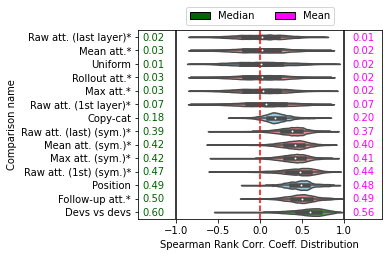

In [21]:
from matplotlib.patches import Patch

means = df_spearman.groupby('comparison_name')['spearman_res.corr'].mean()
medians = df_spearman.groupby('comparison_name')['spearman_res.corr'].median()

fig, ax = plt.subplots(figsize=(5.5, 3.7))

names_as_display_order = means.sort_values().index
palette = {
    "tl_spearman" + k: v for k, v in colors_mapping.items()}
nl_mapping = {
    "tl_spearman" + k: v for k, v in naming_mapping.items()}

sns.violinplot(
    data=df_spearman,
    x="spearman_res.corr",
    y="comparison_name",
    order=names_as_display_order,
    palette=palette,
    ax=ax
)
for i, name in enumerate(names_as_display_order):
    ax.text(
        -1.40, i + 0.25, f"{medians[name]:.2f}", color='darkgreen')
    ax.text(
        1.1, i + 0.25, f"{means[name]:.2f}", color='magenta')

# replace the labels with the natural language names
ax.set_yticklabels([
    nl_mapping[n] + '*'
    if "att." in nl_mapping[n] else nl_mapping[n]
    for n in names_as_display_order])

#plt.setp(ax.collections, alpha=.3)
#plt.scatter(y=range(len(means)), x=means, color='red', marker='o')
#plt.scatter(y=range(len(medians)), x=medians, color='darkgreen', marker='X')
# vertical line on -1 and +1
ax.axvline(x=-1, color='black')
ax.axvline(x=1, color='black')
# red in zero
ax.axvline(x=0, color='red', linestyle='--')
ax.set_xlabel("Spearman Rank Corr. Coeff. Distribution")
ax.set_ylabel("Comparison name")
plt.xlim(-1.45, 1.45)

# add legend with magenta and green patches
legend_elements = [
    Patch(facecolor='darkgreen', edgecolor='black', label='Median'),
    Patch(facecolor='magenta', edgecolor='black', label='Mean'),]
# position the legend above outside the plot
ax.legend(
    handles=legend_elements, loc='upper center', 
    bbox_to_anchor=(0.5, 1.15), ncol=2)

plt.tight_layout()
fig.savefig(
    os.path.join(OUT_PAPER_FOLDER, "tl_spearman_all_comparisons.pdf"))

## Top-K

In [22]:
df = df_codegen[
    (df_codegen['comparison_name'].str.contains('tl_top3')) &
    ~(df_codegen['comparison_name'].str.contains('pair')) & 
    ~(df_codegen['comparison_name'].str.contains('followup_max'))]

col_name = "top_3.value"
# remove invalid comparisons
df = df[df[col_name] != -1]
# convert col_name to string
df[col_name] = df[col_name].astype(int).astype(str)
# weight the datapoint for the time spent on the starting token
df = replicated_based_on_token_visibility(
    df=df,
    df_tokens_w_time=df_tokens_w_time.copy(), 
    short_col_name='top_3',
    weight_column_name='n_replicas_abs')
df = df.reset_index(drop=True)

# keep only those in the nl mapping
df = df[df['comparison_name'].isin([
    "tl_top3" + n for n in naming_mapping.keys()])]
    
df_top3 = df

/home/eaftan/copilot-attention/attwizard/visualizer/eda.py:275: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


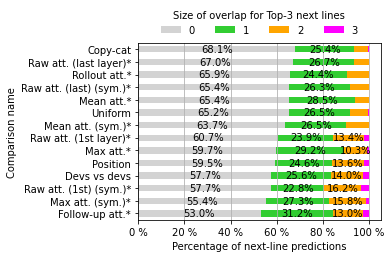

In [23]:

from attwizard.visualizer.eda import plot_100_perc_stacked_bar

nl_mapping = {
    "tl_top3" + k: v for k, v in naming_mapping.items()}

# sort based on the percentage of zeros for each group
ascending_order = df_top3.groupby('comparison_name')['top_3.value'].value_counts(normalize=True).loc[:, '0'].sort_values().index

fig, ax = plot_100_perc_stacked_bar(
    df=df_top3,
    col_name_group="comparison_name",
    col_name_category_in_group=col_name,
    direction='horizontal',
    group_order=ascending_order,
    #group_order=sorted(names_as_display_order, reverse=True),
    n_cols_legend=4,
    # color balck, limegree, 
    fmt='{:.1%}',
    color=['lightgray', 'limegreen', 'orange', 'magenta'],
    legend_title='Size of overlap for Top-3 next lines'
)

# replace the labels with the natural language names
ax.set_yticklabels([
    nl_mapping[n] + '*'
    if "att." in nl_mapping[n] else nl_mapping[n]
    for n in ascending_order
])

ax.set_xlabel("Percentage of next-line predictions")
ax.set_ylabel("Comparison name")
fig.set_size_inches(5.5, 3.7)
plt.tight_layout()

fig.savefig(
    os.path.join(OUT_PAPER_FOLDER, "tl_top3_all_comparisons.pdf"))

# Ablation Study

In [31]:
layer_naming_mapping = {
 '_divide_all_dist_followup_layer_pair_0': 'Layer 0-1',
 '_divide_all_dist_followup_layer_pair_3': 'Layer 3-4',
 '_divide_all_dist_followup_layer_pair_6': 'Layer 6-7',
 '_divide_all_dist_followup_layer_pair_9': 'Layer 9-10',
 '_divide_all_dist_followup_layer_pair_12': 'Layer 12-13',
 '_divide_all_dist_followup_layer_pair_15': 'Layer 15-16',
 '_divide_all_dist_followup_layer_pair_18': 'Layer 18-19',
 '_divide_all_dist_followup_layer_pair_21': 'Layer 21-22',
 '_divide_all_dist_followup_layer_pair_24': 'Layer 24-25',
 '_divide_all_dist_followup_layer_pair_27': 'Layer 27-28',
 '_divide_all_dist_followup_layer_pair_30': 'Layer 30-31',
 '_divide_all_dist_followup_layer_pair_32': 'Layer 32-33',
 '_divide_all_dist_followup': 'All layers',
}
n_generated_tokens_naming_mapping = {
 '_divide_all_dist_followup_max_10_all_layers': '10 tokens',
 '_divide_all_dist_followup_max_50_all_layers': '50 tokens',
 '_divide_all_dist_followup': '100 tokens',
}

## Layer-wise analysis

In [32]:
df = df_codegen[
    (df_codegen['comparison_name'].str.contains('followup')) &
    ~(df_codegen['comparison_name'].str.contains('followup_max'))]

col_name = "top_3.value"
# remove invalid comparisons
df = df[df[col_name] != -1]
# drop nan values
df = df.dropna(subset=[col_name])
# convert col_name to string
df[col_name] = df[col_name].astype(int).astype(str)
# weight the datapoint for the time spent on the starting token
df = replicated_based_on_token_visibility(
    df=df,
    df_tokens_w_time=df_tokens_w_time.copy(), 
    short_col_name='top_3',
    weight_column_name='n_replicas_abs')
df = df.reset_index(drop=True)
df_top3_layers = df

/home/eaftan/copilot-attention/attwizard/visualizer/eda.py:275: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


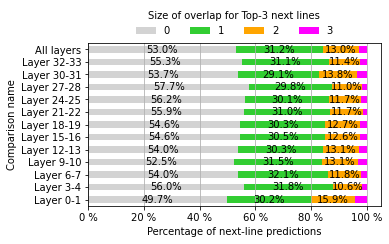

In [33]:

from attwizard.visualizer.eda import plot_100_perc_stacked_bar

nl_mapping = {
    "tl_top3" + k: v for k, v in layer_naming_mapping.items()}

# sort based on the percentage of zeros for each group
#ascending_order = df_top3_layers.groupby('comparison_name')['top_3.value'].value_counts(normalize=True).loc[:, '0'].sort_values().index

definition_order = ["tl_top3" + k for k, v in layer_naming_mapping.items()]

fig, ax = plot_100_perc_stacked_bar(
    df=df_top3_layers,
    col_name_group="comparison_name",
    col_name_category_in_group=col_name,
    direction='horizontal',
    group_order=definition_order,
    #group_order=sorted(names_as_display_order, reverse=True),
    n_cols_legend=4,
    # color balck, limegree, 
    fmt='{:.1%}',
    color=['lightgray', 'limegreen', 'orange', 'magenta'],
    legend_title='Size of overlap for Top-3 next lines'
)

# replace the labels with the natural language names
ax.set_yticklabels([
    nl_mapping[n] + '*'
    if "att." in nl_mapping[n] else nl_mapping[n]
    for n in definition_order
])

ax.set_xlabel("Percentage of next-line predictions")
ax.set_ylabel("Comparison name")
fig.set_size_inches(5.5, 3.5)
plt.tight_layout()

fig.savefig(
    os.path.join(OUT_PAPER_FOLDER, "tl_top3_abl_layers.pdf"))

## No. Generated Tokens

In [34]:
df = df_codegen[
    (df_codegen['comparison_name'].str.contains('followup')) &
    ~(df_codegen['comparison_name'].str.contains('pair'))]

col_name = "top_3.value"
# remove invalid comparisons
df = df[df[col_name] != -1]
# drop nan values
df = df.dropna(subset=[col_name])
# convert col_name to string
df[col_name] = df[col_name].astype(int).astype(str)
# weight the datapoint for the time spent on the starting token
df = replicated_based_on_token_visibility(
    df=df,
    df_tokens_w_time=df_tokens_w_time.copy(), 
    short_col_name='top_3',
    weight_column_name='n_replicas_abs')
df = df.reset_index(drop=True)
df_top3_tokens = df

/home/eaftan/copilot-attention/attwizard/visualizer/eda.py:275: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


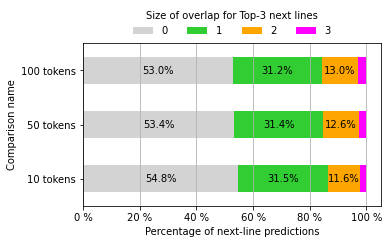

In [35]:
from attwizard.visualizer.eda import plot_100_perc_stacked_bar

nl_mapping = {
    "tl_top3" + k: v for k, v in n_generated_tokens_naming_mapping.items()}

# sort based on the percentage of zeros for each group
#ascending_order = df_top3_tokens.groupby('comparison_name')['top_3.value'].value_counts(normalize=True).loc[:, '0'].sort_values().index

definition_order = ["tl_top3" + k for k, v in n_generated_tokens_naming_mapping.items()]

fig, ax = plot_100_perc_stacked_bar(
    df=df_top3_tokens,
    col_name_group="comparison_name",
    col_name_category_in_group=col_name,
    direction='horizontal',
    group_order=definition_order,
    #group_order=sorted(names_as_display_order, reverse=True),
    n_cols_legend=4,
    # color balck, limegree, 
    fmt='{:.1%}',
    color=['lightgray', 'limegreen', 'orange', 'magenta'],
    legend_title='Size of overlap for Top-3 next lines'
)

# replace the labels with the natural language names
ax.set_yticklabels([
    nl_mapping[n] + '*'
    if "att." in nl_mapping[n] else nl_mapping[n]
    for n in definition_order
])

ax.set_xlabel("Percentage of next-line predictions")
ax.set_ylabel("Comparison name")
fig.set_size_inches(5.5, 3.5)
plt.tight_layout()

fig.savefig(
    os.path.join(OUT_PAPER_FOLDER, "tl_top3_abl_tokens.pdf"))

# Spearman

  0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_3294066/3931153605.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unified_input_human_filestem'] = df.parallel_apply(
  8%|▊         | 1/12 [00:05<01:00,  5.47s/it]

/tmp/ipykernel_3294066/3931153605.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unified_input_human_filestem'] = df.parallel_apply(
 17%|█▋        | 2/12 [00:11<01:00,  6.07s/it]

/tmp/ipykernel_3294066/3931153605.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unified_input_human_filestem'] = df.parallel_apply(
 25%|██▌       | 3/12 [00:18<00:56,  6.23s/it]

/tmp/ipykernel_3294066/3931153605.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unified_input_human_filestem'] = df.parallel_apply(
 33%|███▎      | 4/12 [00:25<00:52,  6.52s/it]

/tmp/ipykernel_3294066/3931153605.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unified_input_human_filestem'] = df.parallel_apply(
 42%|████▏     | 5/12 [00:32<00:46,  6.69s/it]

/tmp/ipykernel_3294066/3931153605.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unified_input_human_filestem'] = df.parallel_apply(
 50%|█████     | 6/12 [00:39<00:41,  6.95s/it]

/tmp/ipykernel_3294066/3931153605.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unified_input_human_filestem'] = df.parallel_apply(
 58%|█████▊    | 7/12 [00:46<00:34,  6.87s/it]

/tmp/ipykernel_3294066/3931153605.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unified_input_human_filestem'] = df.parallel_apply(
 67%|██████▋   | 8/12 [00:53<00:27,  7.00s/it]

/tmp/ipykernel_3294066/3931153605.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unified_input_human_filestem'] = df.parallel_apply(
 75%|███████▌  | 9/12 [01:01<00:21,  7.14s/it]

/tmp/ipykernel_3294066/3931153605.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unified_input_human_filestem'] = df.parallel_apply(
 83%|████████▎ | 10/12 [01:08<00:14,  7.27s/it]

/tmp/ipykernel_3294066/3931153605.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unified_input_human_filestem'] = df.parallel_apply(
 92%|█████████▏| 11/12 [01:16<00:07,  7.45s/it]

/tmp/ipykernel_3294066/3931153605.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unified_input_human_filestem'] = df.parallel_apply(
100%|██████████| 12/12 [01:24<00:00,  7.06s/it]


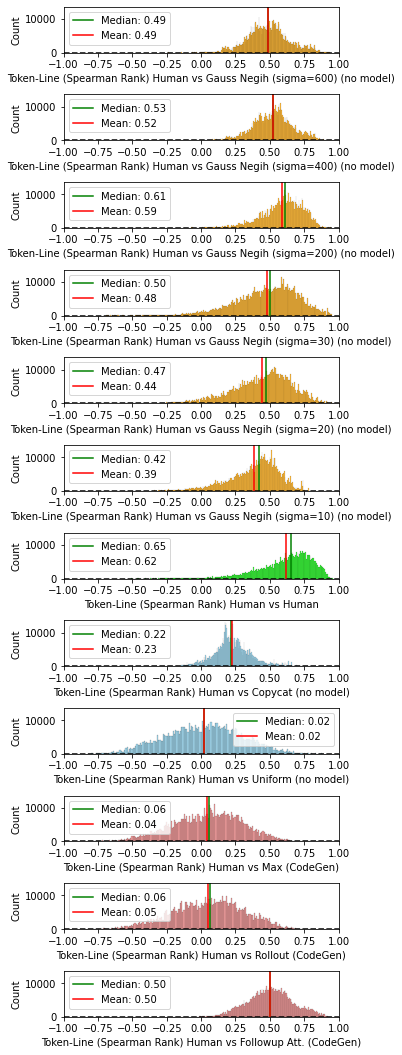

In [13]:
matrix_comparisons = [ 
    {
        "long": "Human vs Gauss Negih (sigma=600) (no model)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_gauss_neigh_600") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'orange',
    },  
    {
        "long": "Human vs Gauss Negih (sigma=400) (no model)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_gauss_neigh_400") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'orange',
    },
    {
        "long": "Human vs Gauss Negih (sigma=200) (no model)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_gauss_neigh_200") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'orange',
    },
    {
        "long": "Human vs Gauss Negih (sigma=30) (no model)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_gauss_neigh_30") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'orange',
    },
    {
        "long": "Human vs Gauss Negih (sigma=20) (no model)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_gauss_neigh_20") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'orange',
    },
    {
        "long": "Human vs Gauss Negih (sigma=10) (no model)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_gauss_neigh_10") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'orange',
    },
    {
        "short": 'human_vs_human',
        'long': 'Human vs Human',
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_humans") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'lime',
    },
    {
        "short": "human_vs_copycat",
        "long": "Human vs Copycat (no model)",
        "data": df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_copycat") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": "human_vs_uniform",
        "long": "Human vs Uniform (no model)",
        "data": df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_uniform") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": "human_vs_max",
        "long": "Human vs Max (CodeGen)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_naivemax") &
            (df_codegen["spearman_res.corr"] != -1)],
        "color": 'lightcoral',
    },
    {
        "short": "human_vs_max",
        "long": "Human vs Rollout (CodeGen)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_rollout_condensed_all") &
            (df_codegen["spearman_res.corr"] != -1)],
        "color": 'lightcoral',
    },
    {
        "short": "human_vs_followup",
        "long": "Human vs Followup Att. (CodeGen)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_followup") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'lightcoral',
    },
]
for el in tqdm(matrix_comparisons):
    df = replicated_based_on_token_visibility(
        df=el['data'], 
        df_tokens_w_time=df_tokens_w_time.copy(), 
        short_col_name='spearman_res',
        weight_column_name='n_replicas_abs')
    el['data'] = df.reset_index(drop=True)
plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="spearman_res.corr",
    common_prefix="Token-Line (Spearman Rank)",
    sharey=True, 
    xlim=(-1, 1),
    vertical_zero_line=True, 
    data_attribute="data",
    #out_path=os.path.join(OUT_PAPER_FOLDER, "tl_spearman_histogram.pdf"),
)

# Top-3

/tmp/ipykernel_3294066/1200812946.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_comparisons["comparison_name"] = df_selected_comparisons["comparison_name"].replace(replace_dict_cmp_names)


/home/eaftan/copilot-attention/attwizard/visualizer/eda.py:273: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


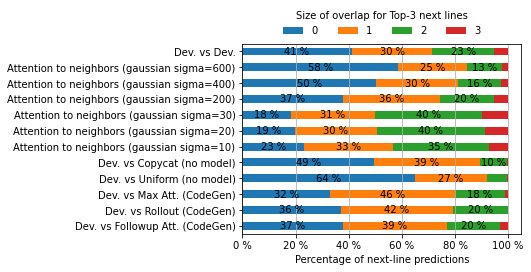

In [14]:
# Top-3 TOKEN-TO-LINE
from attwizard.visualizer.eda import plot_100_perc_stacked_bar

comparisons = [
    {
        "key": "tl_top3_followup",
        "name": "Dev. vs Followup Att. (CodeGen)",
    },
    {
        "key": "tl_top3_rollout_condensed_all",
        "name": "Dev. vs Rollout (CodeGen)",
    },
    {
        "key": "tl_top3_naivemax",
        "name": "Dev. vs Max Att. (CodeGen)",
    },
    {
        "key": "tl_top3_uniform",
        "name": "Dev. vs Uniform (no model)",
    },
    {
        "key": "tl_top3_copycat",
        "name": "Dev. vs Copycat (no model)",
    },
    {
        "key": "tl_top3_gauss_neigh_10",
        "name": "Attention to neighbors (gaussian sigma=10)",
    },
    {
        "key": "tl_top3_gauss_neigh_20",
        "name": "Attention to neighbors (gaussian sigma=20)",
    },
    {
        "key": "tl_top3_gauss_neigh_30",
        "name": "Attention to neighbors (gaussian sigma=30)",
    },
    {
        "key": "tl_top3_gauss_neigh_200",
        "name": "Attention to neighbors (gaussian sigma=200)",
    },
    {
        "key": "tl_top3_gauss_neigh_400",
        "name": "Attention to neighbors (gaussian sigma=400)",
    },
    {
        "key": "tl_top3_gauss_neigh_600",
        "name": "Attention to neighbors (gaussian sigma=600)",
    },
    {
        "key": "tl_top3_humans",
        "name": "Dev. vs Dev.",
    },
]
replace_dict_cmp_names = {
    e['key']: e['name'] for e in comparisons
}
comparison_keys = [e['key'] for e in comparisons]
comparison_names = [e['name'] for e in comparisons]
col_name = "top_3.value"
replace_dict = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
}
df_selected_comparisons = df_codegen[df_codegen["comparison_name"].isin(comparison_keys)]
df_selected_comparisons["comparison_name"] = df_selected_comparisons["comparison_name"].replace(replace_dict_cmp_names)
df_selected_comparisons = df_selected_comparisons[df_selected_comparisons[col_name] != -1]
df_selected_comparisons[col_name] = df_selected_comparisons[col_name].replace(replace_dict)
# weight the datapoint for the time spent on the starting token
df_selected_comparisons = replicated_based_on_token_visibility(
    df=df_selected_comparisons,
    df_tokens_w_time=df_tokens_w_time.copy(), 
    short_col_name='top_3',
    weight_column_name='n_replicas_abs')
df_selected_comparisons = df_selected_comparisons.reset_index(drop=True)

fig, ax = plot_100_perc_stacked_bar(
    df=df_selected_comparisons,
    col_name_group="comparison_name",
    col_name_category_in_group=col_name,
    direction='horizontal',
    group_order=comparison_names,
    n_cols_legend=4,
    legend_title='Size of overlap for Top-3 next lines'
)
ax.set_ylabel(None) 
ax.set_xlabel("Percentage of next-line predictions")
fig.set_size_inches(5, 3.5)
# save fig
#fig.savefig(os.path.join(OUT_PAPER_FOLDER, "tl_top3.pdf"), bbox_inches='tight')

# Top-3 TOKEN-TO-TOKEN - Remove Base Behavior

/tmp/ipykernel_3294066/3291262573.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_comparisons["comparison_name"] = df_selected_comparisons["comparison_name"].replace(replace_dict_cmp_names)


/home/eaftan/copilot-attention/attwizard/visualizer/eda.py:273: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


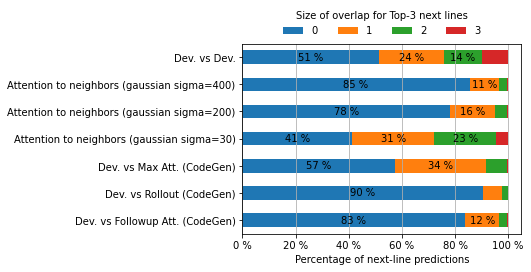

In [15]:
# Top-3 TOKEN-TO-LINE
from attwizard.visualizer.eda import plot_100_perc_stacked_bar

comparisons = [
    {
        "key": "tl_top3_minus_base_followup",
        "name": "Dev. vs Followup Att. (CodeGen)",
    },
    {
        "key": "tl_top3_minus_base_rollout_condensed_all",
        "name": "Dev. vs Rollout (CodeGen)",
    },
    {
        "key": "tl_top3_minus_base_naivemax",
        "name": "Dev. vs Max Att. (CodeGen)",
    },
    {
        "key": "tl_top3_minus_base_gauss_neigh_30",
        "name": "Attention to neighbors (gaussian sigma=30)",
    },
    {
        "key": "tl_top3_minus_base_gauss_neigh_200",
        "name": "Attention to neighbors (gaussian sigma=200)",
    },
    {
        "key": "tl_top3_minus_base_gauss_neigh_400",
        "name": "Attention to neighbors (gaussian sigma=400)",
    },
    {
        "key": "tl_top3_minus_base_humans",
        "name": "Dev. vs Dev.",
    },
]
replace_dict_cmp_names = {
    e['key']: e['name'] for e in comparisons
}
comparison_keys = [e['key'] for e in comparisons]
comparison_names = [e['name'] for e in comparisons]
col_name = "top_3.value"
replace_dict = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
}
df_selected_comparisons = df_codegen[df_codegen["comparison_name"].isin(comparison_keys)]
df_selected_comparisons["comparison_name"] = df_selected_comparisons["comparison_name"].replace(replace_dict_cmp_names)
df_selected_comparisons = df_selected_comparisons[df_selected_comparisons[col_name] != -1]
df_selected_comparisons[col_name] = df_selected_comparisons[col_name].replace(replace_dict)
# weight the datapoint for the time spent on the starting token
df_selected_comparisons = replicated_based_on_token_visibility(
    df=df_selected_comparisons,
    df_tokens_w_time=df_tokens_w_time.copy(), 
    short_col_name='top_3',
    weight_column_name='n_replicas_abs')
df_selected_comparisons = df_selected_comparisons.reset_index(drop=True)

fig, ax = plot_100_perc_stacked_bar(
    df=df_selected_comparisons,
    col_name_group="comparison_name",
    col_name_category_in_group=col_name,
    direction='horizontal',
    group_order=comparison_names,
    n_cols_legend=4,
    legend_title='Size of overlap for Top-3 next lines'
)
ax.set_ylabel(None) 
ax.set_xlabel("Percentage of next-line predictions")
fig.set_size_inches(5, 3.5)
# save fig
#fig.savefig(os.path.join(OUT_PAPER_FOLDER, "tl_top3.pdf"), bbox_inches='tight')

  0%|          | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3294066/3931153605.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unified_input_human_filestem'] = df.parallel_apply(
 14%|█▍        | 1/7 [00:06<00:39,  6.59s/it]

/tmp/ipykernel_3294066/3931153605.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unified_input_human_filestem'] = df.parallel_apply(
 29%|██▊       | 2/7 [00:13<00:34,  6.80s/it]

/tmp/ipykernel_3294066/3931153605.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unified_input_human_filestem'] = df.parallel_apply(
 43%|████▎     | 3/7 [00:20<00:27,  6.97s/it]

/tmp/ipykernel_3294066/3931153605.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unified_input_human_filestem'] = df.parallel_apply(
 57%|█████▋    | 4/7 [00:28<00:21,  7.21s/it]

/tmp/ipykernel_3294066/3931153605.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unified_input_human_filestem'] = df.parallel_apply(
 71%|███████▏  | 5/7 [00:35<00:14,  7.36s/it]

/tmp/ipykernel_3294066/3931153605.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unified_input_human_filestem'] = df.parallel_apply(
 86%|████████▌ | 6/7 [00:43<00:07,  7.51s/it]

/tmp/ipykernel_3294066/3931153605.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unified_input_human_filestem'] = df.parallel_apply(
100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


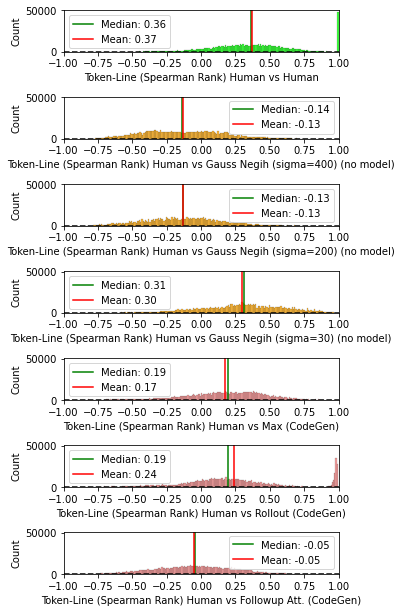

In [18]:

matrix_comparisons = [ 
    {
        "short": 'human_vs_human',
        'long': 'Human vs Human',
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_minus_base_humans") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'lime',
    },
    {
        "long": "Human vs Gauss Negih (sigma=400) (no model)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_minus_base_gauss_neigh_400") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'orange',
    },
    {
        "long": "Human vs Gauss Negih (sigma=200) (no model)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_minus_base_gauss_neigh_200") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'orange',
    },
    {
        "long": "Human vs Gauss Negih (sigma=30) (no model)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_minus_base_gauss_neigh_30") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'orange',
    },
    {
        "short": "human_vs_max",
        "long": "Human vs Max (CodeGen)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_minus_base_naivemax") &
            (df_codegen["spearman_res.corr"] != -1)],
        "color": 'lightcoral',
    },
    {
        "short": "human_vs_max",
        "long": "Human vs Rollout (CodeGen)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_minus_base_rollout_condensed_all") &
            (df_codegen["spearman_res.corr"] != -1)],
        "color": 'lightcoral',
    },
    {
        "short": "human_vs_followup",
        "long": "Human vs Followup Att. (CodeGen)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_minus_base_followup") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'lightcoral',
    },
]
for el in tqdm(matrix_comparisons):
    df = replicated_based_on_token_visibility(
        df=el['data'], 
        df_tokens_w_time=df_tokens_w_time.copy(), 
        short_col_name='spearman_res',
        weight_column_name='n_replicas_abs')
    el['data'] = df.reset_index(drop=True)
plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="spearman_res.corr",
    common_prefix="Token-Line (Spearman Rank)",
    sharey=True, 
    xlim=(-1, 1),
    vertical_zero_line=True, 
    data_attribute="data",
    #out_path=os.path.join(OUT_PAPER_FOLDER, "tl_spearman_histogram.pdf"),
)

# Remove Base - Divide All Dist
Divide by the single 1400 points distribution (0.00001)
The distribution is dependent on the relative position of the token in the code only.

/tmp/ipykernel_3448849/964289610.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_comparisons["comparison_name"] = df_selected_comparisons["comparison_name"].replace(replace_dict_cmp_names)
/home/eaftan/copilot-attention/attwizard/visualizer/eda.py:273: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


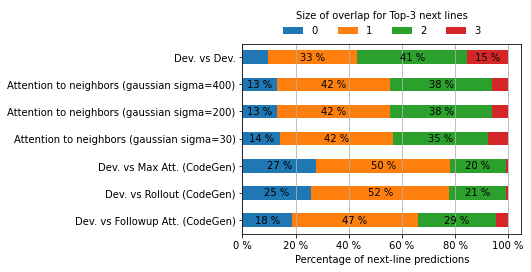

In [9]:
# Top-3 TOKEN-TO-LINE
from attwizard.visualizer.eda import plot_100_perc_stacked_bar

comparisons = [
    {
        "key": "tl_top3_divide_all_dist_followup",
        "name": "Dev. vs Followup Att. (CodeGen)",
    },
    {
        "key": "tl_top3_divide_all_dist_rollout_condensed_all",
        "name": "Dev. vs Rollout (CodeGen)",
    },
    {
        "key": "tl_top3_divide_all_dist_naivemax",
        "name": "Dev. vs Max Att. (CodeGen)",
    },
    {
        "key": "tl_top3_divide_all_dist_gauss_neigh_30",
        "name": "Attention to neighbors (gaussian sigma=30)",
    },
    {
        "key": "tl_top3_divide_all_dist_gauss_neigh_200",
        "name": "Attention to neighbors (gaussian sigma=200)",
    },
    {
        "key": "tl_top3_divide_all_dist_gauss_neigh_400",
        "name": "Attention to neighbors (gaussian sigma=400)",
    },
    {
        "key": "tl_top3_divide_all_dist_humans",
        "name": "Dev. vs Dev.",
    },
]
replace_dict_cmp_names = {
    e['key']: e['name'] for e in comparisons
}
comparison_keys = [e['key'] for e in comparisons]
comparison_names = [e['name'] for e in comparisons]
col_name = "top_3.value"
replace_dict = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
}
df_selected_comparisons = df_codegen[df_codegen["comparison_name"].isin(comparison_keys)]
df_selected_comparisons["comparison_name"] = df_selected_comparisons["comparison_name"].replace(replace_dict_cmp_names)
df_selected_comparisons = df_selected_comparisons[df_selected_comparisons[col_name] != -1]
df_selected_comparisons[col_name] = df_selected_comparisons[col_name].replace(replace_dict)
# weight the datapoint for the time spent on the starting token
df_selected_comparisons = replicated_based_on_token_visibility(
    df=df_selected_comparisons,
    df_tokens_w_time=df_tokens_w_time.copy(), 
    short_col_name='top_3',
    weight_column_name='n_replicas_abs')
df_selected_comparisons = df_selected_comparisons.reset_index(drop=True)

fig, ax = plot_100_perc_stacked_bar(
    df=df_selected_comparisons,
    col_name_group="comparison_name",
    col_name_category_in_group=col_name,
    direction='horizontal',
    group_order=comparison_names,
    n_cols_legend=4,
    legend_title='Size of overlap for Top-3 next lines'
)
ax.set_ylabel(None) 
ax.set_xlabel("Percentage of next-line predictions")
fig.set_size_inches(5, 3.5)
# save fig
#fig.savefig(os.path.join(OUT_PAPER_FOLDER, "tl_top3.pdf"), bbox_inches='tight')

  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_3448849/1440539360.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unified_input_human_filestem'] = df.parallel_apply(
 14%|█▍        | 1/7 [00:06<00:37,  6.18s/it]/tmp/ipykernel_3448849/1440539360.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unified_input_human_filestem'] = df.parallel_apply(
 29%|██▊       | 2/7 [00:12<00:32,  6.41s/it]/tmp/ipykernel_3448849/1440539360.py:15: SettingWithCopyWarning: 
A value is trying to be set on a 

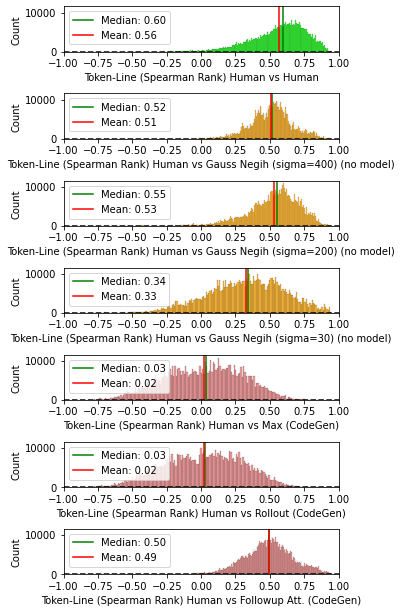

In [12]:
# Spearman Rank
matrix_comparisons = [ 
    {
        "short": 'human_vs_human',
        'long': 'Human vs Human',
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_divide_all_dist_humans") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'lime',
    },
    {
        "long": "Human vs Gauss Negih (sigma=400) (no model)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_divide_all_dist_gauss_neigh_400") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'orange',
    },
    {
        "long": "Human vs Gauss Negih (sigma=200) (no model)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_divide_all_dist_gauss_neigh_200") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'orange',
    },
    {
        "long": "Human vs Gauss Negih (sigma=30) (no model)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_divide_all_dist_gauss_neigh_30") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'orange',
    },
    {
        "short": "human_vs_max",
        "long": "Human vs Max (CodeGen)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_divide_all_dist_naivemax") &
            (df_codegen["spearman_res.corr"] != -1)],
        "color": 'lightcoral',
    },
    {
        "short": "human_vs_max",
        "long": "Human vs Rollout (CodeGen)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_divide_all_dist_rollout_condensed_all") &
            (df_codegen["spearman_res.corr"] != -1)],
        "color": 'lightcoral',
    },
    {
        "short": "human_vs_followup",
        "long": "Human vs Followup Att. (CodeGen)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_divide_all_dist_followup") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'lightcoral',
    },
]
for el in tqdm(matrix_comparisons):
    df = replicated_based_on_token_visibility(
        df=el['data'], 
        df_tokens_w_time=df_tokens_w_time.copy(), 
        short_col_name='spearman_res',
        weight_column_name='n_replicas_abs')
    el['data'] = df.reset_index(drop=True)
plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="spearman_res.corr",
    common_prefix="Token-Line (Spearman Rank)",
    sharey=True, 
    xlim=(-1, 1),
    vertical_zero_line=True, 
    data_attribute="data",
    #out_path=os.path.join(OUT_PAPER_FOLDER, "tl_spearman_histogram.pdf"),
)



# Full Modelling

/tmp/ipykernel_3448849/4063499757.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_comparisons["comparison_name"] = df_selected_comparisons["comparison_name"].replace(replace_dict_cmp_names)
/home/eaftan/copilot-attention/attwizard/visualizer/eda.py:273: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


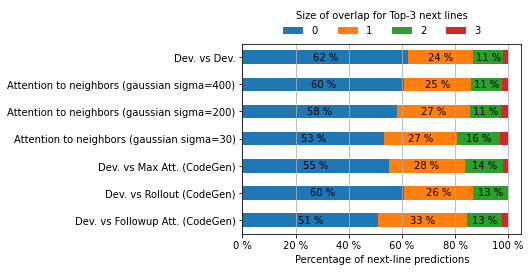

In [17]:
# Top-3 TOKEN-TO-LINE
from attwizard.visualizer.eda import plot_100_perc_stacked_bar

comparisons = [
    {
        "key": "tl_top3_full_modelling_followup",
        "name": "Dev. vs Followup Att. (CodeGen)",
    },
    {
        "key": "tl_top3_full_modelling_rollout_condensed_all",
        "name": "Dev. vs Rollout (CodeGen)",
    },
    {
        "key": "tl_top3_full_modelling_naivemax",
        "name": "Dev. vs Max Att. (CodeGen)",
    },
    {
        "key": "tl_top3_full_modelling_gauss_neigh_30",
        "name": "Attention to neighbors (gaussian sigma=30)",
    },
    {
        "key": "tl_top3_full_modelling_gauss_neigh_200",
        "name": "Attention to neighbors (gaussian sigma=200)",
    },
    {
        "key": "tl_top3_full_modelling_gauss_neigh_400",
        "name": "Attention to neighbors (gaussian sigma=400)",
    },
    {
        "key": "tl_top3_full_modelling_humans",
        "name": "Dev. vs Dev.",
    },
]
replace_dict_cmp_names = {
    e['key']: e['name'] for e in comparisons
}
comparison_keys = [e['key'] for e in comparisons]
comparison_names = [e['name'] for e in comparisons]
col_name = "top_3.value"
replace_dict = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
}
df_selected_comparisons = df_codegen[df_codegen["comparison_name"].isin(comparison_keys)]
df_selected_comparisons["comparison_name"] = df_selected_comparisons["comparison_name"].replace(replace_dict_cmp_names)
df_selected_comparisons = df_selected_comparisons[df_selected_comparisons[col_name] != -1]
df_selected_comparisons[col_name] = df_selected_comparisons[col_name].replace(replace_dict)
# weight the datapoint for the time spent on the starting token
df_selected_comparisons = replicated_based_on_token_visibility(
    df=df_selected_comparisons,
    df_tokens_w_time=df_tokens_w_time.copy(), 
    short_col_name='top_3',
    weight_column_name='n_replicas_abs')
df_selected_comparisons = df_selected_comparisons.reset_index(drop=True)

fig, ax = plot_100_perc_stacked_bar(
    df=df_selected_comparisons,
    col_name_group="comparison_name",
    col_name_category_in_group=col_name,
    direction='horizontal',
    group_order=comparison_names,
    n_cols_legend=4,
    legend_title='Size of overlap for Top-3 next lines'
)
ax.set_ylabel(None) 
ax.set_xlabel("Percentage of next-line predictions")
fig.set_size_inches(5, 3.5)
# save fig
#fig.savefig(os.path.join(OUT_PAPER_FOLDER, "tl_top3.pdf"), bbox_inches='tight')

  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_3448849/1440539360.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unified_input_human_filestem'] = df.parallel_apply(
 14%|█▍        | 1/7 [00:07<00:42,  7.09s/it]/tmp/ipykernel_3448849/1440539360.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unified_input_human_filestem'] = df.parallel_apply(
 29%|██▊       | 2/7 [00:14<00:35,  7.20s/it]/tmp/ipykernel_3448849/1440539360.py:15: SettingWithCopyWarning: 
A value is trying to be set on a 

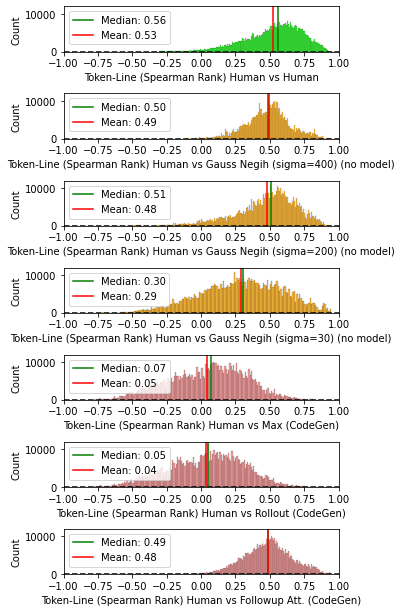

In [18]:

# Spearman Rank
matrix_comparisons = [ 
    {
        "short": 'human_vs_human',
        'long': 'Human vs Human',
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_full_modelling_humans") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'lime',
    },
    {
        "long": "Human vs Gauss Negih (sigma=400) (no model)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_full_modelling_gauss_neigh_400") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'orange',
    },
    {
        "long": "Human vs Gauss Negih (sigma=200) (no model)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_full_modelling_gauss_neigh_200") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'orange',
    },
    {
        "long": "Human vs Gauss Negih (sigma=30) (no model)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_full_modelling_gauss_neigh_30") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'orange',
    },
    {
        "short": "human_vs_max",
        "long": "Human vs Max (CodeGen)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_full_modelling_naivemax") &
            (df_codegen["spearman_res.corr"] != -1)],
        "color": 'lightcoral',
    },
    {
        "short": "human_vs_max",
        "long": "Human vs Rollout (CodeGen)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_full_modelling_rollout_condensed_all") &
            (df_codegen["spearman_res.corr"] != -1)],
        "color": 'lightcoral',
    },
    {
        "short": "human_vs_followup",
        "long": "Human vs Followup Att. (CodeGen)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_spearman_full_modelling_followup") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'lightcoral',
    },
]
for el in tqdm(matrix_comparisons):
    df = replicated_based_on_token_visibility(
        df=el['data'], 
        df_tokens_w_time=df_tokens_w_time.copy(), 
        short_col_name='spearman_res',
        weight_column_name='n_replicas_abs')
    el['data'] = df.reset_index(drop=True)
plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="spearman_res.corr",
    common_prefix="Token-Line (Spearman Rank)",
    sharey=True, 
    xlim=(-1, 1),
    vertical_zero_line=True, 
    data_attribute="data",
    #out_path=os.path.join(OUT_PAPER_FOLDER, "tl_spearman_histogram.pdf"),
)



# MISCELLANEA

In [ ]:
# MSE TOKEN-TO-TOKEN
matrix_comparisons = [   
    {
        "short": "human_vs_followup",
        "long": "Human vs Followup Att. (CodeGen)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tt_mse_followup") & 
            (df_codegen["mse.value"] != -1)],
        'color': 'lightcoral',
    },
    {
        "short": "human_vs_max",
        "long": "Human vs Max Att. (CodeGen)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tt_mse_naivemax") &
            (df_codegen["mse.value"] != -1)],
        "color": 'lightcoral',
    },
    {
        "short": "human_vs_uniform",
        "long": "Human vs Uniform (no model)",
        "data": df_codegen[
            (df_codegen["comparison_name"] == "tt_mse_uniform") &
            (df_codegen["mse.value"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": "human_vs_copycat",
        "long": "Human vs Copycat (no model)",
        "data": df_codegen[
            (df_codegen["comparison_name"] == "tt_mse_copycat") &
            (df_codegen["mse.value"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": 'human_vs_human',
        'long': 'Human vs Human',
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tt_mse_humans") &
            (df_codegen["mse.value"] != -1)],
        'color': 'lime',
    }
]

for el in matrix_comparisons:
    df = replicated_based_on_token_visibility(
        el['data'], 
        df_tokens_w_time, 
        'mse',
        'n_replicas_perc')
    el['data'] = df.reset_index(drop=True)

plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="mse.value",
    common_prefix="Tok-Tok (MSE)",
    #bins=np.arange(0, 0.0002, 0.00001),
    bins=np.logspace(np.log10(10e-7), np.log10(0.007), 100),
    scale="log",
    fmt=".2e",
    sharey=True, 
    vertical_zero_line=True, 
    data_attribute="data",
    #out_path=os.path.join(OUT_PAPER_FOLDER, "tt_mse_histogram_simple.pdf"),
)

In [ ]:
# MSE TOKEN-TO-LINE
matrix_comparisons = [   
    {
        "short": "human_vs_followup",
        "long": "Human vs Followup Att. (CodeGen)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_mse_followup") & 
            (df_codegen["mse.value"] != -1)],
        'color': 'lightcoral',
    },
    {
        "short": "human_vs_max",
        "long": "Human vs Max Att. (CodeGen)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_mse_naivemax") &
            (df_codegen["mse.value"] != -1)],
        "color": 'lightcoral',
    },
    {
        "short": "human_vs_uniform",
        "long": "Human vs Uniform (no model)",
        "data": df_codegen[
            (df_codegen["comparison_name"] == "tl_mse_uniform") &
            (df_codegen["mse.value"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": "human_vs_copycat",
        "long": "Human vs Copycat (no model)",
        "data": df_codegen[
            (df_codegen["comparison_name"] == "tl_mse_copycat") &
            (df_codegen["mse.value"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": 'human_vs_human',
        'long': 'Human vs Human',
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_mse_humans") &
            (df_codegen["mse.value"] != -1)],
        'color': 'lime',
    }
]

for el in matrix_comparisons:
    df = replicated_based_on_token_visibility(
        el['data'], 
        df_tokens_w_time, 
        'mse',
        'n_replicas_perc')
    el['data'] = df.reset_index(drop=True)

plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="mse.value",
    common_prefix="Tok-Line (MSE)",
    #bins=np.arange(0, 0.0002, 0.00001),
    bins=np.logspace(np.log10(10e-7), np.log10(0.007), 100),
    scale="log",
    fmt=".2e",
    sharey=True, 
    vertical_zero_line=True, 
    data_attribute="data",
    #out_path=os.path.join(OUT_PAPER_FOLDER, "tl_mse_histogram_simple.pdf"),
)

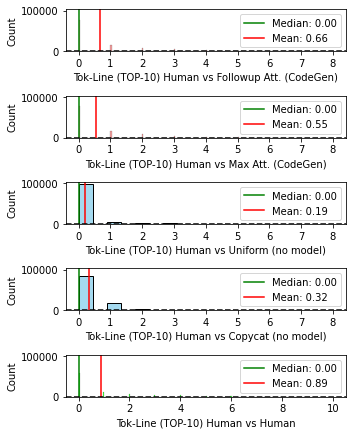

In [47]:
# TOP-10 TOKEN-TO-TOKEN
df_codegen = model_dfs[0]
matrix_comparisons = [   
    {
        "short": "human_vs_followup",
        "long": "Human vs Followup Att. (CodeGen)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tt_top10_followup") & 
            (df_codegen["top_10.value"] != -1)],
        'color': 'lightcoral',
    },
    {
        "short": "human_vs_max",
        "long": "Human vs Max Att. (CodeGen)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tt_top10_naivemax") &
            (df_codegen["top_10.value"] != -1)],
        "color": 'lightcoral',
    },
    {
        "short": "human_vs_uniform",
        "long": "Human vs Uniform (no model)",
        "data": df_codegen[
            (df_codegen["comparison_name"] == "tt_top10_uniform") &
            (df_codegen["top_10.value"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": "human_vs_copycat",
        "long": "Human vs Copycat (no model)",
        "data": df_codegen[
            (df_codegen["comparison_name"] == "tt_top10_copycat") &
            (df_codegen["top_10.value"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": 'human_vs_human',
        'long': 'Human vs Human',
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tt_top10_humans") &
            (df_codegen["top_10.value"] != -1)],
        'color': 'lime',
    }
]

plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="top_10.value",
    common_prefix="Tok-Line (TOP-10)",
    sharey=True, 
    vertical_zero_line=True, 
    data_attribute="data",
    out_path=os.path.join(OUT_PAPER_FOLDER, "tt_top10_histogram.pdf"),
)

In [ ]:
# SPEARMAN TOKEN-TO-TOKEN
matrix_comparisons = [   
    {
        "short": "human_vs_followup",
        "long": "Human vs Followup Att. (CodeGen)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tt_spearman_followup") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'lightcoral',
    },
    {
        "short": "human_vs_max",
        "long": "Human vs Max Att. (CodeGen)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tt_spearman_naivemax") &
            (df_codegen["spearman_res.corr"] != -1)],
        "color": 'lightcoral',
    },
    {
        "short": "human_vs_uniform",
        "long": "Human vs Uniform (no model)",
        "data": df_codegen[
            (df_codegen["comparison_name"] == "tt_spearman_uniform") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": "human_vs_copycat",
        "long": "Human vs Copycat (no model)",
        "data": df_codegen[
            (df_codegen["comparison_name"] == "tt_spearman_copycat") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": 'human_vs_human',
        'long': 'Human vs Human',
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tt_spearman_humans") &
            (df_codegen["spearman_res.corr"] != -1)],
        'color': 'lime',
    }
]
# for el in matrix_comparisons:
#     df = replicated_based_on_token_visibility(
#         el['data'], 
#         df_tokens_w_time, 
#         'spearman_res',
#         'n_replicas_perc')
#     el['data'] = df.reset_index(drop=True)

plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="spearman_res.corr",
    common_prefix="Token-Token (Spearman Rank)",
    sharey=True, 
    xlim=(-1, 1),
    vertical_zero_line=True, 
    data_attribute="data",
    #out_path=os.path.join(OUT_PAPER_FOLDER, "tt_spearman_histogram.pdf"),
)


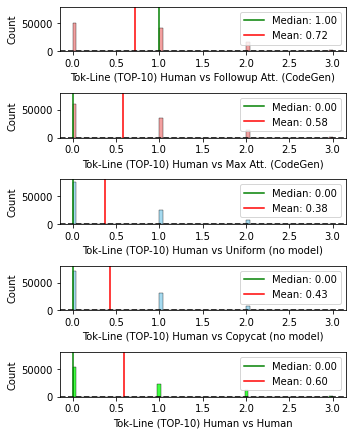

In [15]:
# TOP-3 TOKEN-TO-LINE old format
matrix_comparisons = [   
    {
        "short": "human_vs_followup",
        "long": "Human vs Followup Att. (CodeGen)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_top3_followup") & 
            (df_codegen["top_3.value"] != -1)],
        'color': 'lightcoral',
    },
    {
        "short": "human_vs_max",
        "long": "Human vs Max Att. (CodeGen)",
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_top3_naivemax") &
            (df_codegen["top_3.value"] != -1)],
        "color": 'lightcoral',
    },
    {
        "short": "human_vs_uniform",
        "long": "Human vs Uniform (no model)",
        "data": df_codegen[
            (df_codegen["comparison_name"] == "tl_top3_uniform") &
            (df_codegen["top_3.value"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": "human_vs_copycat",
        "long": "Human vs Copycat (no model)",
        "data": df_codegen[
            (df_codegen["comparison_name"] == "tl_top3_copycat") &
            (df_codegen["top_3.value"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": 'human_vs_human',
        'long': 'Human vs Human',
        'data': df_codegen[
            (df_codegen["comparison_name"] == "tl_top3_humans") &
            (df_codegen["top_3.value"] != -1)],
        'color': 'lime',
    }
]

plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="top_3.value",
    common_prefix="Tok-Line (TOP-3)",
    sharey=True, 
    vertical_zero_line=True, 
    data_attribute="data",
    out_path=os.path.join(OUT_PAPER_FOLDER, "tl_top3_histogram.pdf"),
)

/tmp/ipykernel_2918335/2439668643.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_comparisons["comparison_name"] = df_selected_comparisons["comparison_name"].replace(replace_dict_cmp_names)
/home/eaftan/copilot-attention/attwizard/visualizer/eda.py:273: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


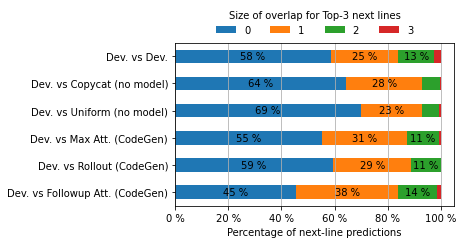

# Normalized Rank

In [ ]:
# normalize the ranking and convert it as percentage of the method length
relevant_comparisons = [
    'tt_rank_followup',
    'tt_rank_naivemax',
    'tt_rank_uniform',
    'tt_rank_copycat',
    'tt_rank_humans',
    'tl_rank_followup',
    'tl_rank_naivemax',
    'tl_rank_uniform',
    'tl_rank_copycat',
    'tl_rank_humans',
]
df = df_codegen[df_codegen["comparison_name"].isin(relevant_comparisons)]
# clean source_file
df["source_code"] = df["source_code"].apply(lambda x: x.split("/")[-1])
df = df[df["rank.value"] != -1]
print(len(df))
df["source_code"].unique()
# LOAD METADATA (with info on snippet length)
all_machine_metadata = read_data_in_parallel(
    base_folder='../data/model_output/exp_v10/codegen/metadata',
    file_type_extension='.json',
    read_function=load_json_file
)
all_records = []
for key, value in all_machine_metadata.items():
    all_records.append({
        'source_code': value['source_file'],
        'snippet_length_tokens': len(value['tokens_prompt']),
        'snippet_length_lines': value['text_prompt'].count('\n')
    })
df_machine_metadata = pd.DataFrame.from_records(all_records)
df_machine_metadata = df_machine_metadata.drop_duplicates(subset=['source_code'])
df_machine_metadata.head()
# AUGMENT DATAFRAME WITH SNIPPET LENGTH
df_augmented = df.merge(df_machine_metadata, left_on='source_code', right_on='source_code')
# normalize the ranking and convert it as percentage of the method length
df_augmented["rank.value_norm_tokens"] = (df_augmented["rank.value"] / df_augmented["snippet_length_tokens"]) * 100
df_augmented["rank.value_norm_lines"] = (df_augmented["rank.value"] / df_augmented["snippet_length_lines"]) * 100
print(len(df_augmented))

In [ ]:
# RANK NORAMALIZED TOKEN-TO-TOKEN
matrix_comparisons = [   
    {
        "short": "human_vs_followup",
        "long": "Human vs Followup Att. (CodeGen)",
        'data': df_augmented[
            (df_augmented["comparison_name"] == "tt_rank_followup") & 
            (df_augmented["rank.value"] != -1)],
        'color': 'lightcoral',
    },
    {
        "short": "human_vs_max",
        "long": "Human vs Max Att. (CodeGen)",
        'data': df_augmented[
            (df_augmented["comparison_name"] == "tt_rank_naivemax") &
            (df_augmented["rank.value"] != -1)],
        "color": 'lightcoral',
    },
    {
        "short": "human_vs_uniform",
        "long": "Human vs Uniform (no model)",
        "data": df_augmented[
            (df_augmented["comparison_name"] == "tt_rank_uniform") &
            (df_augmented["rank.value"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": "human_vs_copycat",
        "long": "Human vs Copycat (no model)",
        "data": df_augmented[
            (df_augmented["comparison_name"] == "tt_rank_copycat") &
            (df_augmented["rank.value"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": 'human_vs_human',
        'long': 'Human vs Human',
        'data': df_augmented[
            (df_augmented["comparison_name"] == "tt_rank_humans") &
            (df_augmented["rank.value"] != -1)],
        'color': 'lime',
    }
]

plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="rank.value_norm_tokens",
    common_prefix="Tok-Tok (rank %)",    
    bins=np.arange(0, 100),
    fmt=".0f",
    sharey=True, 
    vertical_zero_line=True, 
    data_attribute="data",
    #out_path=os.path.join(OUT_PAPER_FOLDER, "tt_rank_histogram_simple.pdf"),
)


In [ ]:
# RANK TOKEN-to-LINE
matrix_comparisons = [   
    {
        "short": "human_vs_followup",
        "long": "Human vs Followup Att. (CodeGen)",
        'data': df_augmented[
            (df_augmented["comparison_name"] == "tl_rank_followup") & 
            (df_augmented["rank.value"] != -1)],
        'color': 'lightcoral',
    },
    {
        "short": "human_vs_max",
        "long": "Human vs Max Att. (CodeGen)",
        'data': df_augmented[
            (df_augmented["comparison_name"] == "tl_rank_naivemax") &
            (df_augmented["rank.value"] != -1)],
        "color": 'lightcoral',
    },
    {
        "short": "human_vs_uniform",
        "long": "Human vs Uniform (no model)",
        "data": df_augmented[
            (df_augmented["comparison_name"] == "tl_rank_uniform") &
            (df_augmented["rank.value"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": "human_vs_copycat",
        "long": "Human vs Copycat (no model)",
        "data": df_augmented[
            (df_augmented["comparison_name"] == "tl_rank_copycat") &
            (df_augmented["rank.value"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": 'human_vs_human',
        'long': 'Human vs Human',
        'data': df_augmented[
            (df_augmented["comparison_name"] == "tl_rank_humans") &
            (df_augmented["rank.value"] != -1)],
        'color': 'lime',
    }
]


plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="rank.value_norm_lines",
    common_prefix="Tok-Line (rank %)",    
    bins=np.arange(0, 100),
    fmt=".0f",
    sharey=True, 
    vertical_zero_line=True, 
    data_attribute="data",
    #out_path=os.path.join(OUT_PAPER_FOLDER, "tl_rank_histogram_simple.pdf"),
)

# Gaussian Neighborhood

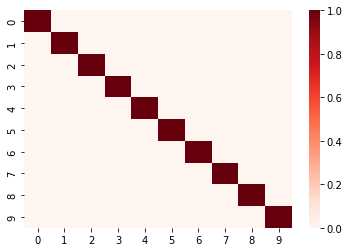

<AxesSubplot:>

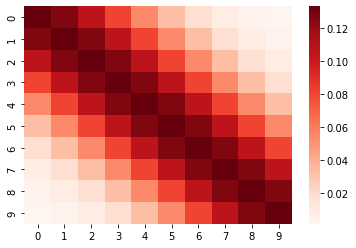

In [135]:
from scipy import ndimage

SIZE = 10
# create a diagonal matrix
m = np.diag(np.ones(SIZE))
sns.heatmap(
    data=m,
    cmap="Reds",
)
plt.show()
for i in range(SIZE):
    row = m[i, :]
    # convert to float
    row = row.astype(float)
    m[i, :] = ndimage.gaussian_filter1d(
        input=np.float_(row), 
        sigma=3,
        cval=0.0,
        mode='constant',)

sns.heatmap(
    data=m,
    cmap="Reds",
)


In [131]:
folder = COMPARISON_FOLDER_CODEGEN
relevant_comparisons = [
    "tl_top3_gauss_neigh_10",
    "tl_top3_gauss_neigh_20",
    "tl_top3_gauss_neigh_30",
]
path_comparison_dir = f'../data/comparisons/{folder}/'
dfs = []
for comparison in tqdm(relevant_comparisons):
    df = pd.read_csv(os.path.join(path_comparison_dir, f'{comparison}.csv'))
    dfs.append(df)
df = pd.concat(dfs)
loaded_comparisons = list(df["comparison_name"].unique())
print(loaded_comparisons)
df_codegen_gaussian = df

100%|██████████| 3/3 [00:16<00:00,  5.46s/it]

['tl_top3_gauss_neigh_10', 'tl_top3_gauss_neigh_20', 'tl_top3_gauss_neigh_30']


/tmp/ipykernel_3016177/718347258.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_comparisons["comparison_name"] = df_selected_comparisons["comparison_name"].replace(replace_dict_cmp_names)
/home/eaftan/copilot-attention/attwizard/visualizer/eda.py:273: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


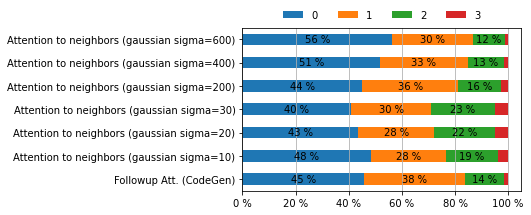

In [45]:
from attwizard.visualizer.eda import plot_100_perc_stacked_bar

comparisons = [
    {
        "key": "tl_top3_followup",
        "name": "Followup Att. (CodeGen)",
    },
    {
        "key": "tl_top3_gauss_neigh_10",
        "name": "Attention to neighbors (gaussian sigma=10)",
    },
    {
        "key": "tl_top3_gauss_neigh_20",
        "name": "Attention to neighbors (gaussian sigma=20)",
    },
    {
        "key": "tl_top3_gauss_neigh_30",
        "name": "Attention to neighbors (gaussian sigma=30)",
    },
    {
        "key": "tl_top3_gauss_neigh_200",
        "name": "Attention to neighbors (gaussian sigma=200)",
    },
    {
        "key": "tl_top3_gauss_neigh_400",
        "name": "Attention to neighbors (gaussian sigma=400)",
    },
    {
        "key": "tl_top3_gauss_neigh_600",
        "name": "Attention to neighbors (gaussian sigma=600)",
    },
]
replace_dict_cmp_names = {
    e['key']: e['name'] for e in comparisons
}
comparison_keys = [e['key'] for e in comparisons]
comparison_names = [e['name'] for e in comparisons]
col_name = "top_3.value"
replace_dict = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
}
df_selected_comparisons = df_codegen[df_codegen["comparison_name"].isin(comparison_keys)]
df_selected_comparisons["comparison_name"] = df_selected_comparisons["comparison_name"].replace(replace_dict_cmp_names)
df_selected_comparisons = df_selected_comparisons[df_selected_comparisons[col_name] != -1]
df_selected_comparisons[col_name] = df_selected_comparisons[col_name].replace(replace_dict)

fig, ax = plot_100_perc_stacked_bar(
    df=df_selected_comparisons,
    col_name_group="comparison_name",
    col_name_category_in_group=col_name,
    direction='horizontal',
    group_order=comparison_names,
    n_cols_legend=4
)
ax.set_ylabel(None) 
fig.set_size_inches(5, 3)
# save fig
#fig.savefig(os.path.join(OUT_PAPER_FOLDER, "abl_study_rollout_tl_top3.pdf"), bbox_inches='tight')

# Exclude +-2 neighboring lines

/tmp/ipykernel_3016177/3807655281.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_comparisons["comparison_name"] = df_selected_comparisons["comparison_name"].replace(replace_dict_cmp_names)
/home/eaftan/copilot-attention/attwizard/visualizer/eda.py:273: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


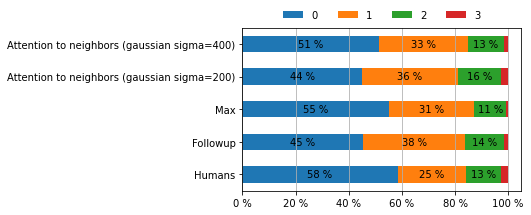

In [23]:
from attwizard.visualizer.eda import plot_100_perc_stacked_bar

comparisons = [
    {
        "key": "tl_top3_far2_humans",
        "name": "Humans",
    },
    {
        "key": "tl_top3_far2_followup",
        "name": "Followup",
    },
    {
        "key": "tl_top3_far2_naivemax",
        "name": "Max",
    },
    {
        "key": "tl_top3_far2_gauss_neigh_200",
        "name": "Attention to neighbors (gaussian sigma=200)",
    },
    {
        "key": "tl_top3_far2_gauss_neigh_400",
        "name": "Attention to neighbors (gaussian sigma=400)",
    },
]
replace_dict_cmp_names = {
    e['key']: e['name'] for e in comparisons
}
comparison_keys = [e['key'] for e in comparisons]
comparison_names = [e['name'] for e in comparisons]
col_name = "top_3.value"
replace_dict = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
}
df_selected_comparisons = df_codegen[df_codegen["comparison_name"].isin(comparison_keys)]
df_selected_comparisons["comparison_name"] = df_selected_comparisons["comparison_name"].replace(replace_dict_cmp_names)
df_selected_comparisons = df_selected_comparisons[df_selected_comparisons[col_name] != -1]
df_selected_comparisons[col_name] = df_selected_comparisons[col_name].replace(replace_dict)

fig, ax = plot_100_perc_stacked_bar(
    df=df_selected_comparisons,
    col_name_group="comparison_name",
    col_name_category_in_group=col_name,
    direction='horizontal',
    group_order=comparison_names,
    n_cols_legend=4
)
ax.set_ylabel(None) 
fig.set_size_inches(5, 3)
# save fig
#fig.savefig(os.path.join(OUT_PAPER_FOLDER, "abl_study_rollout_tl_top3.pdf"), bbox_inches='tight')

In [24]:
df_flw = df_codegen[df_codegen["comparison_name"] == "tl_top3_far2_followup"]
df_flw_old = df_codegen[df_codegen["comparison_name"] == "tl_top3_followup"]

In [40]:
# check if the elements are the same
relevant_columns = ["top_3.value", "input_human_filestem", "input_machine_filestem", "top_3.token_index"]
df_flw_relevant = df_flw[relevant_columns]
df_flw_old_relevant = df_flw_old[relevant_columns]

# iterate over rows 
for i, row in df_flw_relevant.iterrows():
    # get the row in the old df
    row_old = df_flw_old_relevant[
        (df_flw_old_relevant["input_human_filestem"] == row["input_human_filestem"]) &
        (df_flw_old_relevant["input_machine_filestem"] == row["input_machine_filestem"]) &
        (df_flw_old_relevant["top_3.token_index"] == row["top_3.token_index"])
    ]
    if len(row_old) != 1:
        print("ERROR: comparisons not present in old df")
        print(row_old)
        print(row)
        break
    else:
        row_old = row_old.iloc[0]
        if row_old["top_3.value"] != row["top_3.value"]:
            print("ERROR")
        else:
            print("OK")


OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
ERROR
OK
OK
OK
OK
OK
OK
OK
OK
OK
ERROR
ERROR
ERROR
ERROR
ERROR
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
O

KeyboardInterrupt: 

In [33]:
df_flw.equals(df_flw_old)

False

In [26]:
df_flw.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 149406 entries, ('tl_top3_far2_followup', 0) to ('tl_top3_far2_followup', 149405)
Data columns (total 66 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   comparison_name                                     149406 non-null  object 
 1   comparison_function                                 149406 non-null  object 
 2   source_code                                         149406 non-null  object 
 3   user_name_a                                         0 non-null       object 
 4   task_number_a                                       0 non-null       float64
 5   user_name_b                                         0 non-null       object 
 6   task_number_b                                       0 non-null       float64
 7   human_a                                             0 non-null       object 
 8   human_b   

In [27]:
df_flw['input_human_filestem'].unique()

array(['0480e5', '08147e', '09601c', '0d7601', '1181b7', '155d45',
       '161f21', '1d5b6a', '2babb5', '300bd1', '38606b', '3b0e57',
       '3b39e2', '3d9b54', '3e474f', '4022a9', '403482', '43e18c',
       '448383', '44d4f6', '44e060', '4a262b', '4a5896', '4c260d',
       '500208', '5403f5', '545804', '548472', '56f44e', '5a70af',
       '5bf279', '639da1', '653139', '6695fa', '675fc1', '6831ef',
       '7740fd', '7a600a', '81a0b9', '842f7a', '88a0ee', '88a31c',
       '93d2e1', '95024d', '97a19f', '98a211', '9bcda0', '9e5778',
       '9fd0c1', 'a4a47a', 'ab1e99', 'ab3a90', 'aecca4', 'afc047',
       'b0172f', 'b3a349', 'b595bc', 'b5c173', 'b6cb6e', 'b7971a',
       'b7c85e', 'b84310', 'b8a651', 'b93c2f', 'bda0b1', 'be9283',
       'bf760e', 'c35fdf', 'c46e6d', 'c46f82', 'c6d8ff', 'c7ca22',
       'cbdc06', 'd214ff', 'd27bf6', 'd3a4b4', 'd401e5', 'd41dd8',
       'd485dd', 'd86a8d', 'dc14ad', 'debcce', 'df2957', 'df7ddd',
       'e0495f', 'e33aac', 'e63ddf', 'e84aa9', 'f4bbec', 'f5e3

In [32]:
record_now = df_flw[(df_flw['input_human_filestem'] == '08147e')][''input_machine_filestem'] #["top_3.value"]
record_now

tl_top3_far2_followup  1521    triangle_Q3.py_0_Salesforce_codegen-16B-multi
                       1522    triangle_Q3.py_0_Salesforce_codegen-16B-multi
                       1523    triangle_Q3.py_0_Salesforce_codegen-16B-multi
                       1524    triangle_Q3.py_0_Salesforce_codegen-16B-multi
                       1525    triangle_Q3.py_0_Salesforce_codegen-16B-multi
                                                   ...                      
                       3070    triangle_Q3.py_2_Salesforce_codegen-16B-multi
                       3071    triangle_Q3.py_2_Salesforce_codegen-16B-multi
                       3072    triangle_Q3.py_2_Salesforce_codegen-16B-multi
                       3073    triangle_Q3.py_2_Salesforce_codegen-16B-multi
                       3074    triangle_Q3.py_2_Salesforce_codegen-16B-multi
Name: input_machine_filestem, Length: 1554, dtype: object